In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [ ]:
# Load the CSV files
stimulus_data = pd.read_csv('./data-01234567/vns_stimulations.csv', header='infer').values
response_data = pd.read_csv('./data-01234567/vns_responses.csv', header='infer').values

stimulus_data = stimulus_data[:,1:].T
response_data = response_data[:,1:].T

vns_data = pd.read_csv('./data-01234567/vns_cervical_rat_data.csv')
activation_data = vns_data[['AB_fibers_activation', 'C_fibers_activation']].values * 100

# print the sizes with text
print('stimulus_data:', stimulus_data.shape)
print('response_data:', response_data.shape)
print('activation_data:', activation_data.shape)

stimulus_data: (13702, 2498)
response_data: (13702, 2498)
activation_data: (13702, 2)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Reshape data to 2D for scaling (samples, features)
stimulus_data_2d = stimulus_data.reshape((stimulus_data.shape[0], -1))
response_data_2d = response_data.reshape((response_data.shape[0], -1))

# Apply Standardization
stim_scaler = StandardScaler()
stimulus_data_standardized = stim_scaler.fit_transform(stimulus_data_2d)
response_scaler = StandardScaler()
response_data_standardized = response_scaler.fit_transform(response_data_2d)

# Reshape back to original 3D shape (samples, timesteps, 1)
stimulus_data_standardized = stimulus_data_standardized.reshape((stimulus_data.shape[0], stimulus_data.shape[1], 1))
response_data_standardized = response_data_standardized.reshape((response_data.shape[0], response_data.shape[1], 1))

# standardize activation data
activation_scaler = StandardScaler()
activation_data = activation_scaler.fit_transform(activation_data)

# Split the data into training and testing sets
X_stimulus_train, X_stimulus_test, X_response_train, X_response_test, y_train, y_test = train_test_split(
    stimulus_data_standardized, response_data_standardized, activation_data, test_size=0.2, random_state=42)

In [ ]:
X_stimulus_train.shape

(10961, 2498, 1)

In [ ]:
import keras
from keras import Model
from keras import Input
from keras import layers

# Define input layers for stimulus and response waveforms
input_stimulus = Input(shape=(X_stimulus_train.shape[1], 1), name='stimulus_input')
input_response = Input(shape=(X_response_train.shape[1], 1), name='response_input')

# Define CNN layers for stimulus waveform
stimulus_conv1 = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_stimulus)
stimulus_pool1 = layers.MaxPooling1D(pool_size=2)(stimulus_conv1)
stimulus_conv2 = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(stimulus_pool1)
stimulus_pool2 = layers.MaxPooling1D(pool_size=2)(stimulus_conv1)
stimulus_conv3 = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(stimulus_pool2)
stimulus_pool3 = layers.MaxPooling1D(pool_size=2)(stimulus_conv2)
stimulus_flat = layers.Flatten()(stimulus_pool3)

# Define CNN layers for response waveform
response_conv1 = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_response)
response_pool1 = layers.MaxPooling1D(pool_size=2)(response_conv1)
response_conv2 = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(response_pool1)
response_pool2 = layers.MaxPooling1D(pool_size=2)(stimulus_conv1)
response_conv3 = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(response_pool2)
response_pool3 = layers.MaxPooling1D(pool_size=2)(response_conv2)
response_flat = layers.Flatten()(response_pool3)

# # Concatenate the flattened outputs
concatenated = layers.Concatenate()([stimulus_flat, response_flat])

# Fully connected layers
fc1 = layers.Dense(128, activation='relu')(concatenated)
fc2 = layers.Dense(64, activation='relu')(fc1)
output = layers.Dense(2, activation='sigmoid')(fc2)

# Create the model
model = Model(inputs=[input_stimulus, input_response], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ stimulus_input      │ (None, 2498, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ response_input      │ (None, 2498, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2496, 32)  │        128 │ stimulus_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2496, 32)  │        128 │ response_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1248, 32)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1248, 32)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1246, 32)  │      3,104 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1246, 32)  │      3,104 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 623, 32)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 623, 32)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 19936)     │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 19936)     │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 39872)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  5,103,744 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,118,594 (19.53 MB)

 Trainable params: 5,118,594 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit([X_stimulus_train, X_response_train], y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
result = model.evaluate([X_stimulus_test, X_response_test], y_test)


NameError: name 'model' is not defined

In [ ]:
# Test the model
y_pred = model.predict([X_stimulus_test, X_response_test])

86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


In [ ]:
# Check sizes of y_pred and y_test
print('y_pred:', y_pred.shape)
print('y_test:', y_test.shape)

C:\Users\btari\AppData\Local\Temp\ipykernel_20816\1006302561.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


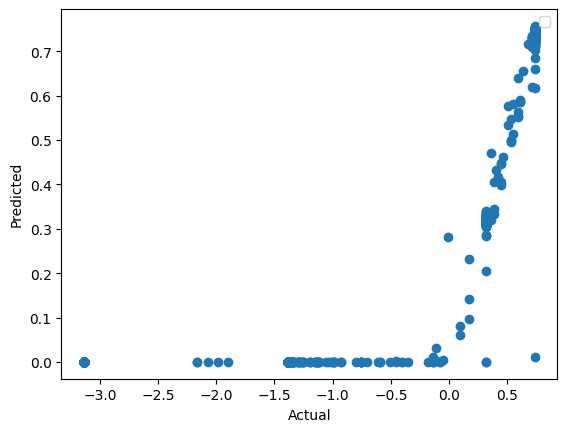

In [ ]:
# Plot a line of the predicted and actual values
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

In [ ]:
# Plot the history
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.plot([0, 30], [result[0], result[0]], label='test', linestyle='--')
plt.xlabel('Epoch')
plt.ylim([0, 50])
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
%reset -f

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the CSV files
stimulus_data = pd.read_csv('/content/drive/MyDrive/VagusNerveResearchProject/vns_stimulations.csv', header='infer').values
response_data = pd.read_csv('/content/drive/MyDrive/VagusNerveResearchProject/vns_responses_noisy.csv', header='infer').values

stimulus_data = stimulus_data[:,1:].T
response_data = response_data[:,1:].T

vns_data = pd.read_csv('/content/drive/MyDrive/VagusNerveResearchProject/vns_cervical_rat_data.csv')
activation_data = vns_data[['AB_fibers_activation', 'C_fibers_activation']].values

# print the sizes with text
print('stimulus_data:', stimulus_data.shape)
print('response_data:', response_data.shape)
print('activation_data:', activation_data.shape)

stimulus_data: (13702, 2498)
response_data: (13702, 2498)
activation_data: (13702, 2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import StandardScaler

# Reshape data to 2D for scaling (samples, features)
stimulus_data_2d = stimulus_data.reshape((stimulus_data.shape[0], -1))
response_data_2d = response_data.reshape((response_data.shape[0], -1))

stim_scaler = StandardScaler()
stimulus_data_standardized = stim_scaler.fit_transform(stimulus_data_2d)
response_scaler = StandardScaler()
response_data_standardized = response_scaler.fit_transform(response_data_2d)

# Reshape back to original 3D shape (samples, timesteps, 1)
stimulus_data_standardized = stimulus_data_standardized.reshape((stimulus_data.shape[0], stimulus_data.shape[1], 1))
response_data_standardized = response_data_standardized.reshape((response_data.shape[0], response_data.shape[1], 1))

# standardize activation data
activation_scaler = StandardScaler()
activation_data_std = activation_scaler.fit_transform(activation_data)

# Split the data into training and testing sets
X_stimulus_train, X_stimulus_test, X_response_train, X_response_test, y_train, y_test = train_test_split(
    stimulus_data_standardized, response_data_standardized, activation_data_std, test_size=0.2, random_state=53)

X_stimulus_train, X_stimulus_val, X_response_train, X_response_val, y_train, y_val = train_test_split(
    X_stimulus_train, X_response_train, y_train, test_size=0.25, random_state=53)

In [ ]:
%pip install optuna

In [ ]:
import optuna
from keras import Model, Input, layers, optimizers, losses, metrics

def create_model(trial: optuna.Trial):
    # Define hyperparameters to search
    num_conv_layers = trial.suggest_int('num_conv_layers', 0, 3)
    num_fc_layers = trial.suggest_int('num_fc_layers', 0 if num_conv_layers > 0 else 1, 3)
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-4, 1e-5])

    # Define input layers for stimulus and response waveforms
    input_stimulus = Input(shape=(X_stimulus_train.shape[1], 1), name='stimulus_input')
    input_response = Input(shape=(X_response_train.shape[1], 1), name='response_input')

    # Define CNN layers for stimulus waveform
    x = input_stimulus
    for i in range(num_conv_layers):
        filters = trial.suggest_categorical(f'num_filters_{i+1}_stimulus', [8, 16, 32, 48, 64])
        kernel_size = trial.suggest_int(f'kernel_size_{i+1}_stimulus', 2, 5)
        stride = trial.suggest_int(f'stride_{i+1}_stimulus', 1, 3)
        pool_size = trial.suggest_int(f'pool_size_{i+1}_stimulus', 2, 4)
        x = layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=stride, activation='relu')(x)
        x = layers.MaxPooling1D(pool_size=pool_size)(x)
    stimulus_flat = layers.Flatten()(x)

    # Define CNN layers for response waveform
    y = input_response
    for i in range(num_conv_layers):
        filters = trial.suggest_categorical(f'num_filters_{i+1}_response', [8, 16, 32, 48, 64])
        kernel_size = trial.suggest_int(f'kernel_size_{i+1}_response', 2, 5)
        stride = trial.suggest_int(f'stride_{i+1}_response', 1, 3)
        pool_size = trial.suggest_int(f'pool_size_{i+1}_response', 2, 4)
        y = layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=stride, activation='relu')(y)
        y = layers.MaxPooling1D(pool_size=pool_size)(y)
    response_flat = layers.Flatten()(y)

    # Concatenate the flattened outputs
    concatenated = layers.Concatenate()([stimulus_flat, response_flat])

    for i in range(num_fc_layers):
        units = trial.suggest_categorical(f'dense_units_{i+1}',  [8, 16, 32, 64, 128])
        concatenated = layers.Dense(units, activation='relu')(concatenated)

    output = layers.Dense(2)(concatenated)

    # Create the model
    model = Model(inputs=[input_stimulus, input_response], outputs=output)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=losses.MeanSquaredError(), metrics=[metrics.MeanAbsoluteError()])

    return model

def objective(trial):
    model = create_model(trial)

    # Train the model
    history = model.fit(
        [X_stimulus_train, X_response_train], y_train,
        epochs=50,
        batch_size=32,
        validation_data=([X_stimulus_val, X_response_val], y_val),
        verbose=0
    )

    # Evaluate the model
    result = model.evaluate([X_stimulus_val, X_response_val], y_val, verbose=0)

    mse = result[0]
    num_params = model.count_params()

    # Define score as a combination of validation MSE and number of parameters

    # score = mse*10 + num_params * 1e-7

    # return score  # Return the validation MSE as the optimization target
    return mse, num_params

# Create the study and optimize
study = optuna.create_study(directions=['minimize', 'minimize'])


[I 2024-09-04 01:01:48,523] A new study created in memory with name: no-name-b95fd2a3-1bd4-4b9f-a37d-f797c684ee3e


In [9]:
study.optimize(objective, n_trials=25)

[I 2024-09-04 01:02:44,358] Trial 0 finished with values: [0.3038793206214905, 319938.0] and parameters: {'num_conv_layers': 0, 'num_fc_layers': 1, 'learning_rate': 1e-05, 'dense_units_1': 64}.
[I 2024-09-04 01:03:22,299] Trial 1 finished with values: [0.07306366413831711, 639874.0] and parameters: {'num_conv_layers': 0, 'num_fc_layers': 1, 'learning_rate': 0.001, 'dense_units_1': 128}.
[I 2024-09-04 01:04:10,849] Trial 2 finished with values: [0.10524580627679825, 41338.0] and parameters: {'num_conv_layers': 0, 'num_fc_layers': 3, 'learning_rate': 1e-05, 'dense_units_1': 8, 'dense_units_2': 16, 'dense_units_3': 64}.
[I 2024-09-04 01:05:45,299] Trial 3 finished with values: [0.006382140330970287, 55562.0] and parameters: {'num_conv_layers': 3, 'num_fc_layers': 3, 'learning_rate': 0.0001, 'num_filters_1_stimulus': 64, 'kernel_size_1_stimulus': 4, 'stride_1_stimulus': 2, 'pool_size_1_stimulus': 3, 'num_filters_2_stimulus': 32, 'kernel_size_2_stimulus': 4, 'stride_2_stimulus': 3, 'pool_si

Best trials:
Trial 1:
  Value: [0.00492766872048378, 34946.0]
  Params: {'num_conv_layers': 3, 'num_fc_layers': 2, 'learning_rate': 0.0001, 'num_filters_1_stimulus': 48, 'kernel_size_1_stimulus': 5, 'stride_1_stimulus': 3, 'pool_size_1_stimulus': 4, 'num_filters_2_stimulus': 48, 'kernel_size_2_stimulus': 3, 'stride_2_stimulus': 3, 'pool_size_2_stimulus': 2, 'num_filters_3_stimulus': 64, 'kernel_size_3_stimulus': 5, 'stride_3_stimulus': 2, 'pool_size_3_stimulus': 3, 'num_filters_1_response': 32, 'kernel_size_1_response': 2, 'stride_1_response': 1, 'pool_size_1_response': 3, 'num_filters_2_response': 64, 'kernel_size_2_response': 3, 'stride_2_response': 3, 'pool_size_2_response': 2, 'num_filters_3_response': 8, 'kernel_size_3_response': 2, 'stride_3_response': 3, 'pool_size_3_response': 3, 'dense_units_1': 8, 'dense_units_2': 128}
Trial 2:
  Value: [0.015154530294239521, 7282.0]
  Params: {'num_conv_layers': 2, 'num_fc_layers': 0, 'learning_rate': 0.001, 'num_filters_1_stimulus': 64, 'ke

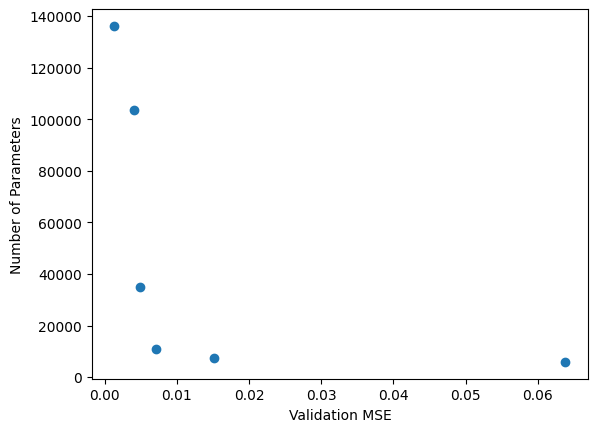

In [10]:
import matplotlib.pyplot as plt

# Get the best hyperparameters
best_trials = study.best_trials
print('Best trials:')
for i, trial in enumerate(best_trials):
    print(f'Trial {i+1}:')
    print(f'  Value: {trial.values}')
    print(f'  Params: {trial.params}')

plt.figure()
plt.scatter([trial.values[0] for trial in best_trials], [trial.values[1] for trial in best_trials])
# plt.xlim([0, 20])
plt.xlabel('Validation MSE')
plt.ylabel('Number of Parameters')
plt.show()

In [12]:
best_trial = best_trials[4]
best_hyperparams = best_trial.params

# Create and compile the best model
best_model = create_model(optuna.trial.FixedTrial(best_hyperparams))
best_model.summary()

# Train the best model
history = best_model.fit(
    [X_stimulus_train, X_response_train], y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_stimulus_val, X_response_val], y_val)
)

# Evaluate the best model
final_score = best_model.evaluate([X_stimulus_test, X_response_test], y_test)
print(f"Final score (test MSE): {final_score[0]}")


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ stimulus_input            │ (None, 2498, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ response_input            │ (None, 2498, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_90 (Conv1D)        │ (None, 1248, 16)       │             80 │ stimulus_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_93 (Conv1D)        │ (None, 1248, 8)        │             32 │ response_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_90          │ (None, 416, 16)        │              0 │ conv1d_90[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_93          │ (None, 312, 8)         │              0 │ conv1d_93[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_91 (Conv1D)        │ (None, 415, 32)        │          1,056 │ max_pooling1d_90[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_94 (Conv1D)        │ (None, 104, 48)        │          1,200 │ max_pooling1d_93[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_91          │ (None, 103, 32)        │              0 │ conv1d_91[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_94          │ (None, 26, 48)         │              0 │ conv1d_94[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_92 (Conv1D)        │ (None, 34, 64)         │          6,208 │ max_pooling1d_91[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_95 (Conv1D)        │ (None, 8, 64)          │         12,352 │ max_pooling1d_94[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_92          │ (None, 8, 64)          │              0 │ conv1d_92[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_95          │ (None, 4, 64)          │              0 │ conv1d_95[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_52 (Flatten)      │ (None, 512)            │              0 │ max_pooling1d_92[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_53 (Flatten) 

 Total params: 136,194 (532.01 KB)

 Trainable params: 136,194 (532.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.5220 - mean_absolute_error: 0.4443 - val_loss: 0.0260 - val_mean_absolute_error: 0.0832
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0198 - mean_absolute_error: 0.0768 - val_loss: 0.0137 - val_mean_absolute_error: 0.0636
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - mean_absolute_error: 0.0500 - val_loss: 0.0114 - val_mean_absolute_error: 0.0587
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098 - mean_absolute_error: 0.0556 - val_loss: 0.0081 - val_mean_absolute_error: 0.0434
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056 - mean_absolute_error: 0.0406 - val_loss: 0.0062 - val_mean_absolute_error: 0.0363
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0100 - mean_absolute_error: 0.0489 - val_loss: 0.0046 - val_mean_absolute_error: 0.0332
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0029 - mean_absolute_error: 0

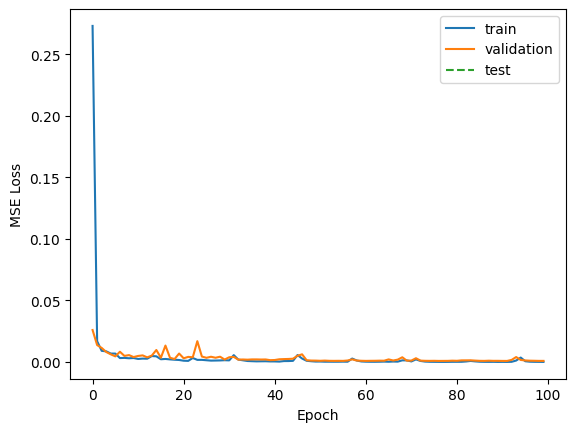

In [13]:
# Plot the history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.plot([0, 0], [final_score[0], final_score[0]], label='test', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [14]:
y_pred = best_model.predict([X_stimulus_test, X_response_test])

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


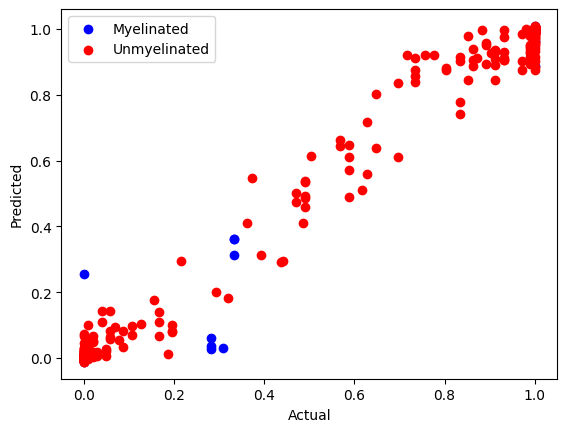

In [15]:
# denormalise
y_pred_denorm = activation_scaler.inverse_transform(y_pred)
y_test_denorm = activation_scaler.inverse_transform(y_test)

plt.scatter(y_test_denorm[:, 0], y_pred_denorm[:, 0], label='Myelinated', color='blue')
plt.scatter(y_test_denorm[:, 1], y_pred_denorm[:, 1], label='Unmyelinated', color='red')
# plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

In [16]:
# save best_model to a file using timestamp and pickle
from datetime import datetime
import pickle

timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
# save the best model to a file using pickle

with open(f'/content/drive/MyDrive/VagusNerveResearchProject/final-models/activation-model-cnn-noisy-{timestamp}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [19]:
# save study to file
import pickle

with open(f'/content/drive/MyDrive/VagusNerveResearchProject/final-models/study-activation-model-cnn-noisy-{timestamp}.pkl', 'wb') as f:
    pickle.dump(study, f)

In [17]:
# load the model back
with open(f'/content/drive/MyDrive/VagusNerveResearchProject/final-models/activation-model-cnn-noisy-{timestamp}.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

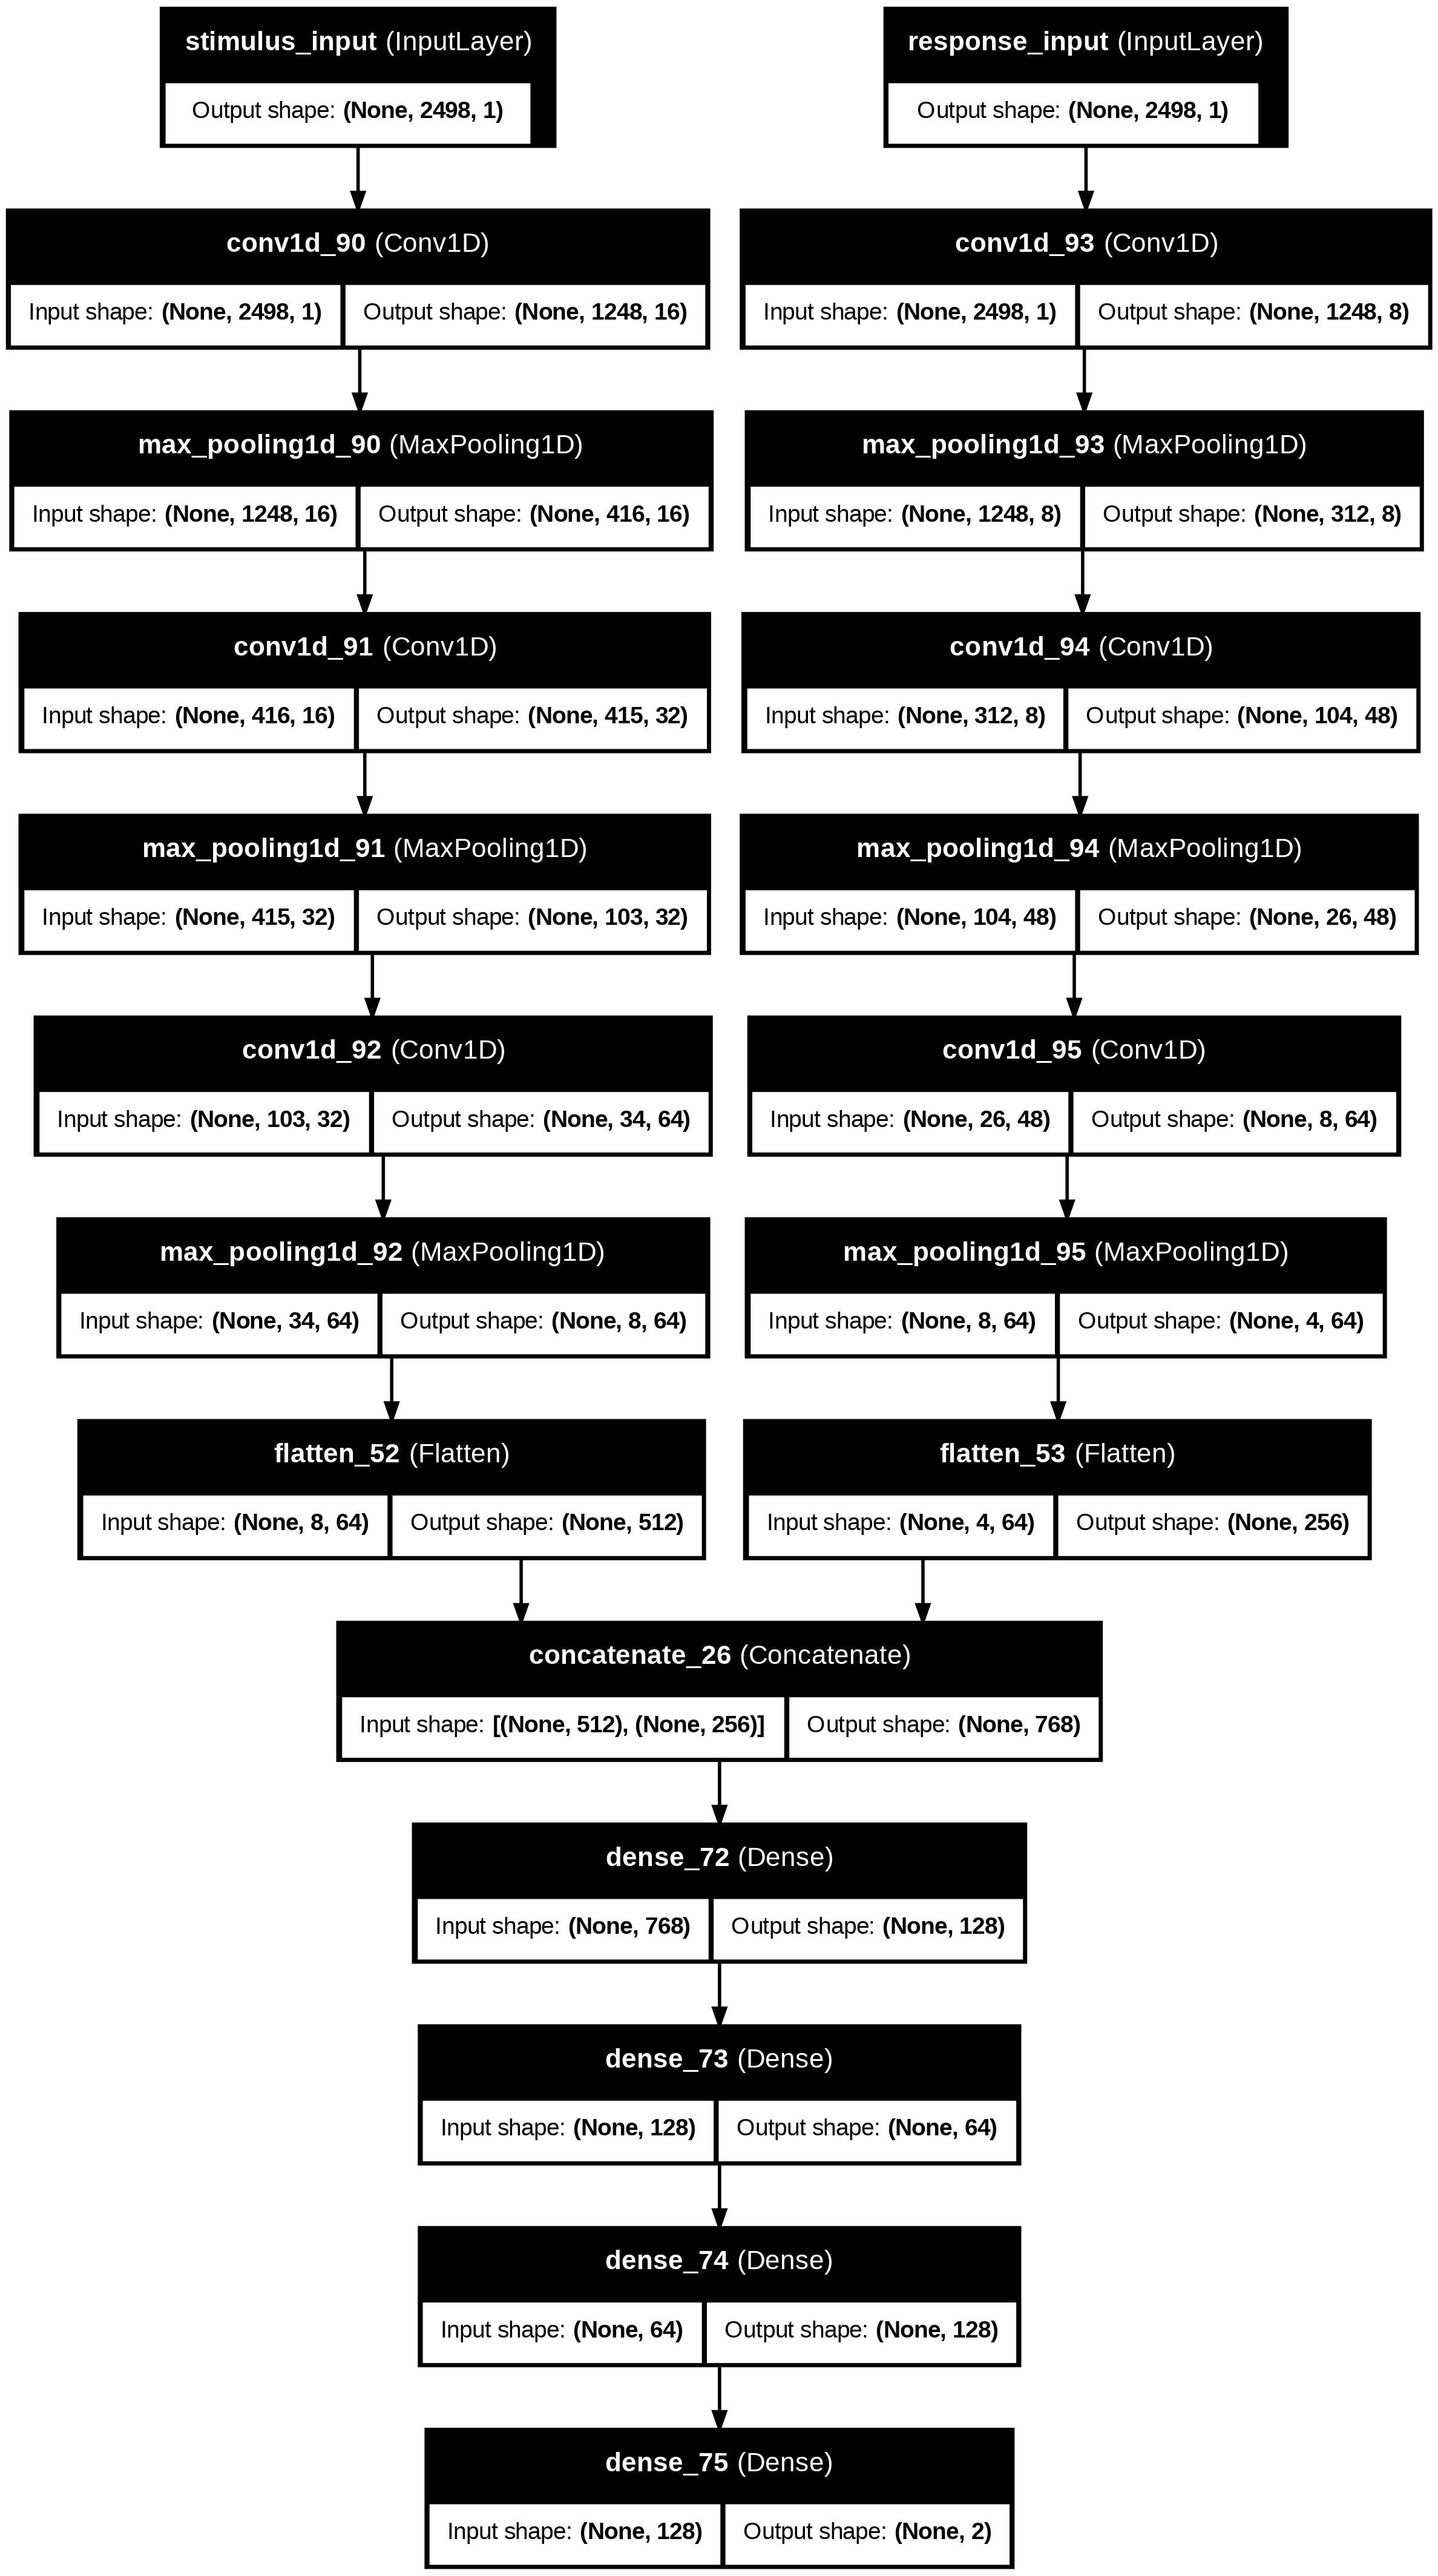

In [18]:
# plot the model
from keras import utils

utils.plot_model(loaded_model, show_shapes=True, show_layer_names=True)

In [ ]:
# save study to a file
import pickle

with open('./models/activation-mo-study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
from optuna.visualization import plot_contour, plot_slice

params=[
    'num_conv_layers',
    'num_fc_layers',
    'num_filters_1_stimulus',
    # 'kernel_size_1_stimulus',
]

plot_contour(study, target=lambda t: t.values[0], params=params)

c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\optuna\visualization\_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [ ]:
plot_slice(study, target=lambda t: t.values[0])

c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\optuna\visualization\_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [ ]:
from optuna.visualization import plot_param_importances
params = [
    'num_conv_layers',
    'num_fc_layers',
    'num_filters_1_stimulus',
    'kernel_size_1_stimulus',
    'stride_1_stimulus',
    'pool_size_1_stimulus',
    'num_filters_1_response',
    'kernel_size_1_response',
    'stride_1_response',
    'pool_size_1_response',
    'dense_units_1',
]
plot_param_importances(study, target=lambda t: t.values[0], params=params)

c:\Users\btari\miniconda3\envs\ml\Lib\site-packages\optuna\visualization\_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [ ]:
# load i2move data and test on model

import pandas as pd
import numpy as np

# Load the CSV files
stimulus_data = pd.read_csv('./data/i2Move/vn_stimulations.csv', header='infer').values
response_data = pd.read_csv('./data/i2Move/vn_data_filtered.csv', header='infer').values
print(stimulus_data.shape)
print(response_data.shape)

(976, 2470)
(976, 2500)


In [ ]:
# pad stimulus with 28 zeros
stimulus_data = np.pad(stimulus_data, ((0, 0), (0, 28)), 'constant')
# remove the last 2 values of response data
response_data = response_data[:, :-2]

print(stimulus_data.shape)
print(response_data.shape)

(976, 2498)
(976, 2498)


In [ ]:
# Reshape data to 2D scaling (samples, features)
stimulus_data_2d = stimulus_data.reshape((stimulus_data.shape[0], -1))
response_data_2d = response_data.reshape((response_data.shape[0], -1))

# Apply Standardization
stimulus_data_standardized = scaler.fit_transform(stimulus_data_2d)
response_data_standardized = scaler.fit_transform(response_data_2d)

# Reshape back to original 3D shape (samples, timesteps, 1)
stimulus_data_standardized = stimulus_data_standardized.reshape((stimulus_data.shape[0], stimulus_data.shape[1], 1))
response_data_standardized = response_data_standardized.reshape((response_data.shape[0], response_data.shape[1], 1))

# test the model
y_pred = best_model.predict([stimulus_data_standardized, response_data_standardized])


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


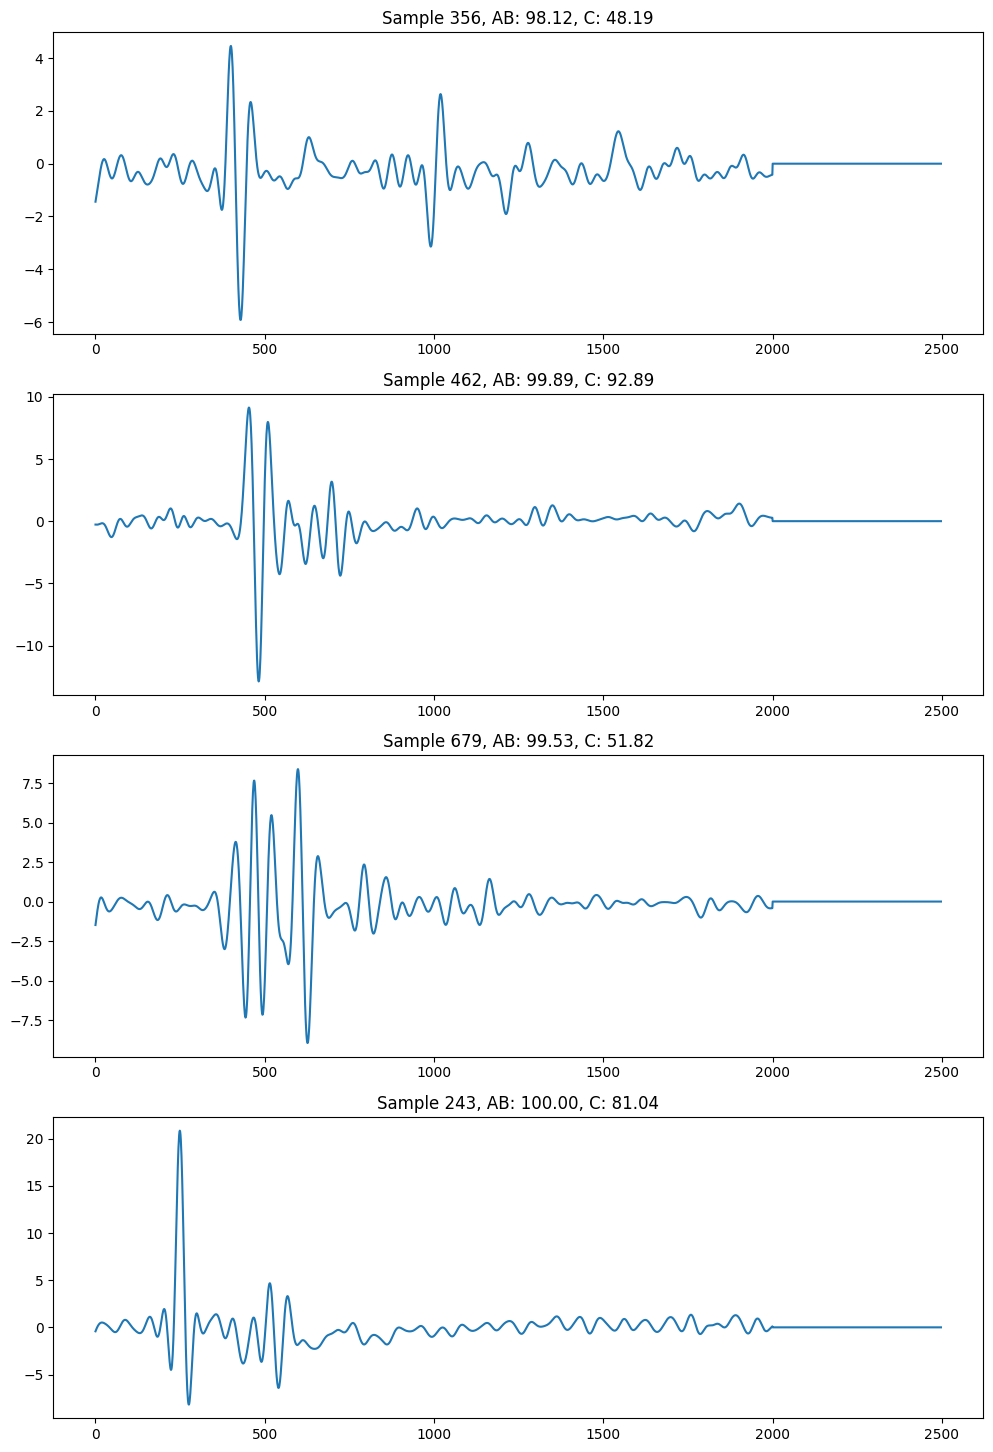

In [ ]:
# Plot some random responses with the predicted values in the title

import matplotlib.pyplot as plt

random_idx = np.random.randint(0, y_pred.shape[0], 4)

fig, ax = plt.subplots(4, 1, figsize=(12, 18))

for i, idx in enumerate(random_idx):
    ax[i].plot(response_data[idx])
    ax[i].set_title(f'Sample {idx}, AB: {y_pred[idx, 0]:.2f}, C: {y_pred[idx, 1]:.2f}')

plt.show()